# `dyvider` tutorial

This tutorial demonstrates the use of [dyvider](https://github.com/jg-you/dyvider), a small package implementing reference code for detecting partitions in networks embedded in one dimension --- sometimes called the "linear clustering problem."

This code is based on the article [\"Fast and exact linear clustering of networks with dynamic programming\"](https://arxiv.org/abs/XXXXXX), by [Alice Patania](), [Antoine Allard](https://antoineallard.github.io/) and [Jean-Gabriel Young](https://jg-you.github.io/). 

**Notebook author**: Jean-Gabriel Young <jean-gabriel.young@uvm.edu><br/>
**Last modified:** January 2023<br/>
**License:** CC BY 4.0<br/>

## Setup

Let's first import the few packages needed for this tutorial.

The strict minimum is `dyvider`---the package implementing the partitioning code---and `networkx`---for storing and manipulating graphs. This is all that is needed to solve the clustering task.
We'll also use plotting and numerical packages.

In [1]:
import networkx as nx             # graph manipulation
import numpy as np                # numerical utilities
import matplotlib.pyplot as plt   # plotting
import itertools as it            # iteration utilities
import pandas as pd               # format results

# TODO: change paths
import sys
sys.path.insert(0, 'dyvider/')
import dyvider as dy


np.random.seed(0)              # set seed for reproducibility

## A first example

The very first step of the process is to create a graph object with node positions.
For the sake of simplicity, we will start with a small synthetic network of 5 nodes.

In [2]:
# First we create a dictionary of scores
# keys are node identifiers, and values are scores (on the real line)
score = {0: 9.3,
         1: 8.3,
         2: 4.1,
         3: 1.5,
         4: 0.3}

# Let's now instantiate a graph with these scores
g = nx.Graph()
g.add_nodes_from([0, 1, 2, 3, 4])
nx.set_node_attributes(g, values=score, name='score')

# Add edges
g.add_edge(0, 1)
g.add_edge(0, 2)
g.add_edge(1, 2)
g.add_edge(2, 3)
g.add_edge(3, 4)

The package expects nodes indexed by contiguous integers starting from 0. Additionally, the package expects that node 0 has the highest score and that scores are stored as the node attribute `score`. In our example, we have already followed this convention. But if a messy graph is loaded instead, we provide a helper function to apply these transformations automatically to any graph with a `score` node attribute:

In [3]:
# this function **does not** modify the graph in-place -- it returns a new graph object
g = dy.utilities.preprocess(g)

Once we have processed the graph, the next step is to define an objective function.

In `dyvider`, objective functions are implemented as `python` classes, and several default objectives can be found in the `objectives` submodule. For this example, we will use the *modularity* objective. It favors layers that are denser than expected according to some null model---by default, the [configuration model](https://en.wikipedia.org/wiki/Configuration_model).

In [4]:
the_objective = dy.objectives.Modularity()

Once we have defined the objective function, we can run the detection algorithm. 

`algorithms.run` provides a convenient interface that automatically selects and runs the best algorithm for the chosen objective. This function takes a graph and an instantiated objective function as inputs. It returns a `Layers` object containing the optimal partition and the numerical value of the optimum of the objective function.

In [5]:
(solution, Q_opt) = dy.algorithms.run(g, the_objective)

`solution` is a `Layers` object and can be manipulated using a few useful methods and data members:

In [6]:
# get the layers as a list of frozensets
solution.as_sets()

# iterate over layers (as frozensets)
for layer in solution:
    layer 

# get the identifier of the layer of a particular node (in the processed formed)
v = 3
solution.layer_of[v];

We will use these methods and `networkx` to visualize the solution.

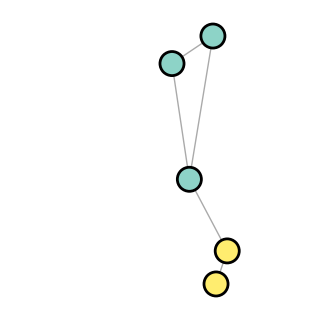

In [7]:
# create a list of node labels from the Layers object
node_labels = [solution.layer_of[v] for v in g.nodes()]

# assign node positions using the "score" of nodes on the vertical
# axis and a random number on the horizontal axis
pos = [np.array([np.random.normal(0, 0.1),
                 score[v]])
       for v in g.nodes()]


# visualize the graph
plt.figure(figsize=(3,3))
nx.draw(g,
        pos=pos,
        node_color=node_labels,
        cmap=plt.cm.Set3,
        edgecolors='k',
        edge_color='#aaa',
        linewidths=2
        )
plt.xlim(-0.5, 0.5);

The objective is maximized by a partition in two layers as can be seen above.
This solution is associated to a quality of:

In [8]:
round(Q_opt / g.number_of_edges(), 3)  # (normalize to put on the standard modularity scale)

0.22

For this small graph, there are only $2^4=16$ possible clustering of the nodes, so we can actually verify that the solution is optimal by brute-force enumeration:

In [9]:
n = g.number_of_nodes()
# iterate over all clusterings
tmp = []
for k in list(range(1, n + 1)):
    for boundaries in it.combinations(range(n - 1), k - 1):
        # create Layers object
        solution = dy.layers.Layers(list(boundaries) + [n - 1])
        # evaluate quality
        Q = the_objective.eval(g, solution)
        # save results
        tmp.append([Q, solution])

The explicit enumeration does show that the solution found by `dyvider` is optimal:

In [10]:
print("Quality  | Solution\n----------------------------------------")
for Q, solution in tmp:
    print("{0: .2f}".format(round(Q / g.number_of_edges(), 3)), "**" if Q == Q_opt else "  ", "|", solution)

Quality  | Solution
----------------------------------------
 0.00    | [[0, 1, 2, 3, 4]]
-0.08    | [[0]; [1, 2, 3, 4]]
 0.08    | [[0, 1]; [2, 3, 4]]
 0.22 ** | [[0, 1, 2]; [3, 4]]
-0.02    | [[0, 1, 2, 3]; [4]]
-0.04    | [[0]; [1]; [2, 3, 4]]
 0.02    | [[0]; [1, 2]; [3, 4]]
-0.14    | [[0]; [1, 2, 3]; [4]]
 0.06    | [[0, 1]; [2]; [3, 4]]
-0.02    | [[0, 1]; [2, 3]; [4]]
 0.06    | [[0, 1, 2]; [3]; [4]]
-0.06    | [[0]; [1]; [2]; [3, 4]]
-0.14    | [[0]; [1]; [2, 3]; [4]]
-0.14    | [[0]; [1, 2]; [3]; [4]]
-0.10    | [[0, 1]; [2]; [3]; [4]]
-0.22    | [[0]; [1]; [2]; [3]; [4]]


The optimal solution regroups nodes 0, 1 and 2 in one layer; and nodes 3 and 4 in a second layer, in line with the graph drawn in the cell above.

## Choosing the algorithm

The `dyvider` package implements several detection algorithms, all in the `algorithms` submodule.
They all take a graph and an instantiated objective as input and return a solution to the partitioning problem.

Some are optimal maximizers (`brute_force`, `naive_dp`, `pair_sum_dp`), while others are approximative maximizers (e.g., `pure_greedy`, `critical_gap`, `heap_merge`).

To run a specific algorithm, we need to call them directly instead of relying on the high-level interface `run`.
A direct call would look like this:

In [11]:
solution, Q = dy.algorithms.brute_force(g, the_objective)

For example, let's compare the solution found by several algorithms on the partitioning task introduced above.

In [12]:
results = dict()
for (algo_name, algo) in [("naive_dp", dy.algorithms.naive_dp),
                          ("brute_force", dy.algorithms.brute_force),
                          ("critica_gap", dy.algorithms.critical_gap),
                          ("heap_merge", dy.algorithms.heap_merge),
                          ("pure_greedy", dy.algorithms.greedy)]:
    results[algo_name] = algo(g, the_objective)

Since the problem is easy, we find similar results with nearly all methods. 
Only the critical gap method---a greedy optimizer---does not.

In [13]:
print("Algorithm\t | Q*   | Layers \n----------------------------------------------")
for k, v in results.items():
    print(k+"\t", "{0:.2f}".format(round(v[1] / g.number_of_edges(), 3)), v[0], sep=" | ")

Algorithm	 | Q*   | Layers 
----------------------------------------------
naive_dp	 | 0.22 | [[0, 1, 2]; [3, 4]]
brute_force	 | 0.22 | [[0, 1, 2]; [3, 4]]
critica_gap	 | 0.08 | [[0, 1]; [2, 3, 4]]
heap_merge	 | 0.22 | [[0, 1, 2]; [3, 4]]
pure_greedy	 | 0.22 | [[0, 1, 2]; [3, 4]]


## Using different objectives

As seen above, objective functions are python classes in `dyvider`.
We provide several built-in objective functions in the submodule `objectives`. 

* For undirected graphs:
    * `objectives.Partitioning`: Objective that increases with the number of edges inside layers. Includes a tunable quadratic penalty term to discourage large layers.
    * `objectives.Modularity`: Objective that increases with the difference between the number of edges inside layers and the *expected*  number of layers, as predicted by a null model. We have implemented the configuration model and the Erdős–Rényi null models.
* For directed graphs:
    * `objectives.Egalitarian`: Objective that increases with the number of reciprocated edges inside layers. Includes a penalty term to discourage large layers.
    * `objectives.Dominance`: Objective that decreases with the number of unreciprocated edges inside layers. Includes a penalty term to discourage empty layers.
    


### Example of built-in objective

For example, let's revisit the partitioning problem above with a different objective, the partitioning objective

$$ Q(\mathcal{L})= \sum_{r} (m_r - \lambda n_r^2)$$

where $m_r$ is the number of edges with both ends in layer $r$, and $n_r$ is the number of nodes, and $\lambda\in\mathbb{R}$ is a tuning parameter.

In [14]:
# the tuning parameter is passed via "penalty."
the_objective = dy.objectives.Partitioning(penalty=0.2)
dy.algorithms.run(g, the_objective)

([[0, 1, 2]; [3, 4]], 1.3999999999999997)

In this case, we find the same solution as with the modularity objective, but the numerical value associated with the solution is different since the partitioning objective is calculated differently.


Since `dyvider` implements fast detection algorithms, we can easily scan values of the penalty term to check its impact:

In [15]:
resolution = 201
Qs = [None] * resolution
solutions = [None] * resolution
lambda_space = np.linspace(-1, 3, resolution)
for i, penalty in enumerate(lambda_space):
    solutions[i], Qs[i] = dy.algorithms.run(g, dy.objectives.Partitioning(penalty))

Text(0, 0.5, '$q$')

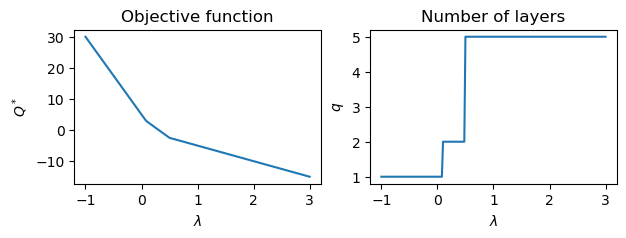

In [16]:
plt.figure(figsize=(7,2))

plt.subplot(121)
plt.title('Objective function')
plt.plot(lambda_space, Qs)
plt.xlabel(r"$\lambda$")
plt.ylabel(r'$Q^*$')

plt.subplot(122)
plt.title('Number of layers')
plt.plot(lambda_space, [len(s) for s in solutions])
plt.xlabel(r"$\lambda$")
plt.ylabel(r'$q$')


We can see that the objective function decreases with the strength of the penalty term, as we subtract an increasingly large number---the penalty itself. We also see that the number of layers in the solution increases with the penalty, as the large penalty term favors smaller layers at the expense of their internal densities.

### Defining custom objectives

Objective functions are classes in  `dyvider`.
At the minimum, these classes must have the following methods:

* `eval_layer(g, upper, lower)` a method that calculates the quality of a layer. `g` is the input graph, while  `upper` and `lower` are the extremal nodes of the layer (included). Note that 0 is at the top in our ordering of nodes, so `upper` <= `lower`.
* `eval(g, layers)`, a helper method that evaluates the quality of a separation in layers. `g` is, again, the input graph, while `layers`  is a `Layers` object with the same number of nodes as `g`.

For example, we could define the quality of a layer as the number of edges it contains to the power of 3, minus the number of nodes in contains to the power of 4. This would be done as:

In [17]:
class CustomObjective(object):
    def __init__(self):
        pass

    def eval_layer(self, g, upper, lower):
        # count edges
        num_edges = 0
        for u, v in it.combinations_with_replacement(range(upper, lower + 1), 2):
            num_edges += g.number_of_edges(u, v)
        # define size    
        num_nodes = (lower - upper)
        return num_edges ** 3 - (lower - upper) ** 4

    def eval(self, g, layers):
        Q = 0
        for L in layers:
            Q += self.eval_layer(g, min(L), max(L))
        return Q

Evaluating this objective on our running example, we find the optimum:

In [18]:
the_objective = CustomObjective()
dy.algorithms.run(g, the_objective)

([[0, 1, 2]; [3]; [4]], 11.0)

The strong penatly on large group leads to two small layers at the bottom of the hierarchy, instead of 1.

### Harnessing accelerated dynamic programming methods

`dyvider` implements several versions of the dynamic programming algorithms, some of which are faster but require special objective functions.

In particular, a $O(n^2)$ solver is available for quality functions that can be written as

$$ Q(L) = \sum_r f(L_r)$$ 

where the quality of layer $f$ is calculated as a sum of pairs of quality increments, as

$$f(L_r) = \sum_{u,v\in L_r} f_{uv}.$$

To enable these fast algorithms, the class defining the objective function should:

1. set `is_pair_sum=True` in its constructor;
2. have a method `eval_pair(self, g, u, v)` that returns the quality increment $f_{uv}$.


For such objectives, fast algorithms labeled by `pair_sum` in their name are available, i.e., `pair_sum_dp`, `pair_sum_heap_merge`, and `pair_sum_critical_gap`. The high-level interface `run` also automatically picks the fast version when called with such objectives.

In [19]:
# Modularity is a built-in pair sum objective:
dy.algorithms.pair_sum_dp(g, dy.objectives.Modularity())

([[0, 1, 2]; [3, 4]], 1.1)

To simplify the definition of pair-sum objectives, we have defined an abstract class, `PairSumObjectives` from which one can derive pair-sum objectives easily. The abstract class defines all the necessary methods except `eval_pair`.


For example, let's implement a "degree-product" objective defined by $f_{uv}=k_uk_v a_{uv} - 1$, where $k_u$ is the degree of node $u$ and $a_{uv}=1$  if  $u$ and $v$ are connected and to $0$ otherwise. This can be done as:

In [20]:
# derive class from PairSumObjectives
class DegreeProduct(dy.objectives.PairSumObjectives):
    
    def __init__(self):
        super().__init__() # call constructor of PairSumObjectives
    
    def eval_pair(self, g, u, v):
        return g.degree(u) * g.degree(v) * g.number_of_edges(u, v) - 1

In [21]:
the_objective = DegreeProduct()
Solution, Q = dy.algorithms.run(g, the_objective)

And the solution for this new obejctive is just separated layers:

In [22]:
print("Solution:", solution)
print("Q:", Q)

Solution: [[0, 1, 2]; [3, 4]]
Q: 11.0
